<a href="https://colab.research.google.com/github/hanhanwu/Hanhan_COLAB_Experiemnts/blob/master/optimization_practice/Cold_Weather_Fuel_Design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cold Weather Fuel Design

* [Problem Statement][1]
* Practice with my solution

[1]:https://github.com/jckantor/ND-Pyomo-Cookbook/blob/main/notebooks/02.04-Mixture-Design-Cold-Weather-Fuel.ipynb

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc 
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))

import pyomo.environ as pyomo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 4.1 MB/s eta 0:00:00
Selecting previously unselected package coinor-libcoinutils3v5.
(Reading database ... 128097 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.11.4+repack1-1_amd64.deb ...
Unpacking coinor-libcoinutils3v5 (2.11.4+repack1-1) ...
Selecting previously unselected package coinor-libosi1v5.
Preparing to unpack .../1-coinor-libosi1v5_0.108.6+repack1-1_amd64.deb ...
Unpacking coinor-libosi1v5 (0.108.6+repack1-1) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.17.5+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.17.5+repack1-1) ...
Selecting previously unselected package coinor-libcgl1.
Preparing to unpack .../3-coinor-libcgl1_0.60.3+repack1-2_amd64.deb ...
Unpacking coinor-libcgl1 (0.60.3+repack1-2) ...
Selecting previously unselecte

In [1]:
data = {
    'ethanol'          : {'MW':  46.07, 'SG': 0.791, 'A': 8.04494, 'B': 1554.3,  'C': 222.65},
    'methanol'         : {'MW':  32.04, 'SG': 0.791, 'A': 7.89750, 'B': 1474.08, 'C': 229.13},
    'isopropyl alcohol': {'MW':  60.10, 'SG': 0.785, 'A': 8.11778, 'B': 1580.92, 'C': 219.61},
    'acetone'          : {'MW':  58.08, 'SG': 0.787, 'A': 7.02447, 'B': 1161.0,  'C': 224.0},
    'xylene'           : {'MW': 106.16, 'SG': 0.870, 'A': 6.99052, 'B': 1453.43, 'C': 215.31},
    'toluene'          : {'MW':  92.14, 'SG': 0.865, 'A': 6.95464, 'B': 1344.8,  'C': 219.48},
}

In [2]:
def Pvap(T, s):
  P = 10 ** (data[s]['A'] - data[s]['B']/ (T + data[s]['C']))

  return P


def P_denatured(T):
  return 0.4 * Pvap(T, 'ethanol') + 0.6 * Pvap(T, 'methanol')

In [6]:
model = pyomo.ConcreteModel()
S = data.keys()
model.x = pyomo.Var(S, domain=pyomo.NonNegativeReals)

def Pmix(T):
  return sum([model.x[s] * Pvap(T, s) for s in S])

model.obj = pyomo.Objective(expr = Pmix(-10), sense=pyomo.maximize)
model.conts = pyomo.ConstraintList()
model.conts.add(sum([model.x[s] for s in S]) == 1)
model.conts.add(sum([model.x[s] * Pvap(30, s) for s in S]) <= P_denatured(30))

solver = pyomo.SolverFactory('cbc')
solver.solve(model)

{'Problem': [{'Name': 'unknown', 'Lower bound': 17.48178543, 'Upper bound': 17.48178543, 'Number of objectives': 1, 'Number of constraints': 3, 'Number of variables': 7, 'Number of nonzeros': 6, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 0.0, 'Wallclock time': 0.01, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': None, 'Number of created subproblems': None}, 'Black box': {'Number of iterations': 2}}, 'Error rc': 0, 'Time': 0.07900714874267578}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

Vapor Pressure at -10°C = 17.48178543436185 mmHg


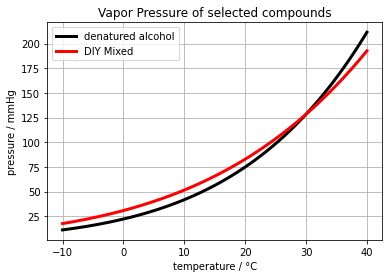

In [8]:
print(f'Vapor Pressure at -10°C = {model.obj()} mmHg')

T = np.linspace(-10,40,200)
plt.plot(T, P_denatured(T), 'k', lw=3, label='denatured alcohol')
plt.plot(T, [Pmix(T)() for T in T], 'r', lw=3, label='DIY Mixed')  # pressure after optimization
plt.legend()
plt.title('Vapor Pressure of selected compounds')
plt.xlabel('temperature / °C')
plt.ylabel('pressure / mmHg')
plt.grid(True)